# Shakespeare Text Generation RNN

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on GitHub
> - ▶️ Demo: [try this model in action](https://trekhleb.github.io/machine-learning-experiments)

## Experiment overview

In this experiment we will use character-based RNN to generate a Shakespeare's-like text based on the Shakespeare dataset from [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) blog post.

_Inspired by [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)_

## Import dependencies

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.6.9
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Download the dataset

In [3]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

1122304/1115394 [==============================] - 0s 0us/step
/content/tmp/datasets/shakespeare.txt


## Analyze the dataset

In [4]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [5]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [7]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
  print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [8]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [9]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


## Create training sequences

In [10]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [11]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
  print(index2char[char.numpy()])

F
i
r
s
t


In [12]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
  print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [0]:
# sequences shape:
# - 11043 sequences
# - Each sequence of length 101
#
#
#    101     101          101
# [(.....) (.....) ...  (.....)]
#
# <---------- 11043 ----------->

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [0]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

In [15]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 11043


In [16]:
for input_example, target_example in dataset.take(1):
  print('Input sequence size:', repr(len(input_example.numpy())))
  print('Target sequence size:', repr(len(target_example.numpy())))
  print()
  print('Input:', repr(''.join(index2char[input_example.numpy()])))
  print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [0]:
# dataset shape:
# - 11043 sequences
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 11043 ------------->

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [18]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
  print('Step {:2d}'.format(i))
  print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
  print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [19]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [20]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 172


In [21]:
for input_text, target_text in dataset.take(1):
  print('1st batch: input_text:', input_text)
  print()
  print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 1 20 47 ... 18 53 56]
 [ 1 39 52 ... 39 58  1]
 [42  6  1 ... 44 43 39]
 ...
 [46 39 58 ... 61 57  2]
 [63 53 59 ... 56  1 57]
 [43  1 52 ... 43 52  1]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[20 47 57 ... 53 56  1]
 [39 52 42 ... 58  1 57]
 [ 6  1 39 ... 43 39 56]
 ...
 [39 58 12 ... 57  2  1]
 [53 59  1 ...  1 57 53]
 [ 1 52 53 ... 52  1 47]], shape=(64, 100), dtype=int64)


In [0]:
# dataset shape:
# - 172 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <--------------------------------- 172 ----------------------------------->

## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU): A type of RNN with size units=rnn_units (You can also use a LSTM layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [23]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[8 3 9 0 6 6 5 9]
 [1 3 5 6 6 1 5 6]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-0.02551216 -0.02949679 -0.01569091  0.040068    0.02007974]
  [ 0.00728285  0.01849962 -0.03346412  0.0439033  -0.02870452]
  [-0.04577632 -0.03793287  0.00344089  0.00791105  0.00466161]
  [ 0.01384342  0.0147084  -0.01430024  0.01254554  0.0492701 ]
  [ 0.00124843 -0.0153901  -0.02805694  0.04302526  0.04831124]
  [ 0.00124843 -0.0153901  -0.02805694  0.04302526  0.04831124]
  [ 0.03677997 -0.02992265  0.03443542 -0.00560228  0.01620484]
  [-0.04577632 -0.03793287  0.00344089  0.00791105  0.00466161]]

 [[-0.02233704  0.01601947  0.00516126 -0.00793169  0.00600386]
  [ 0.00728285  0.01849962 -0.03346412  0.0439033  -0.02870452]
  [ 0.03677997 -0.02992265  0.03443542 -0.00560228  0.01620484]
  [ 0.00124843 -0.0153901  -0.02805694  0.04302526  0.04831124]
  [ 0.00124843 -0.0153901  -0.02805694  0.04302526  0.04831124]
  [-0.02233704  0.01601947 

In [0]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
  ))

  model.add(tf.keras.layers.GRU(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
  ))

  model.add(tf.keras.layers.Dense(vocab_size))
  
  return model

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


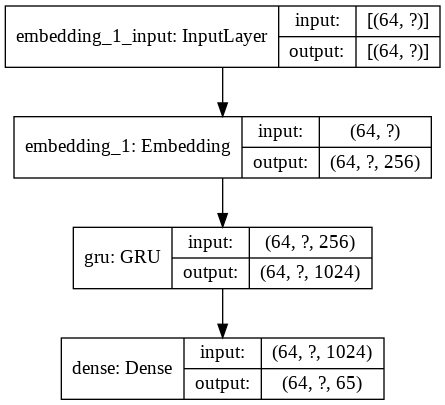

In [28]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Model architecture](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

## Try the model

In [29]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [30]:
  print('Prediction for the 1st letter of the batch 1st sequense:')
  print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-0.00652957 -0.00502459  0.00939825  0.00321739 -0.0031417   0.00982485
 -0.00435612  0.00167589  0.00997406  0.0183353  -0.00506835  0.00632077
 -0.00327305 -0.00884953 -0.00690534 -0.01085346 -0.00806397  0.00946936
 -0.00065058 -0.00359281  0.00034624 -0.0061579  -0.002128    0.000543
  0.00339734 -0.00874294 -0.00535333  0.01376611  0.01207268  0.01792077
 -0.00015426  0.0030445   0.00739965 -0.00020098  0.00617685 -0.00416535
 -0.01517769  0.0002507   0.00784125  0.00453124 -0.01220537 -0.00775002
 -0.01547586  0.00555003  0.00296547 -0.00392368  0.00877909 -0.0107858
 -0.00889687 -0.00454146 -0.00337457  0.00604388 -0.00838828 -0.00087015
  0.00218182  0.00476841  0.00426565 -0.00906088 -0.01189585  0.00219351
  0.0035344  -0.0005277  -0.00335817  0.01194928  0.00172252], shape=(65,), dtype=float32)


In [31]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[1 2 1 2 2]], shape=(1, 5), dtype=int64)


In [32]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [33]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [34]:
sampled_indices

array([46, 50, 53, 24, 49,  5, 28, 40,  3, 27,  5, 27, 57,  4, 51,  8, 47,
        3, 21, 34, 45, 23,  6, 38, 45,  1, 41, 22, 36, 34, 16, 64, 31, 34,
       32, 57,  0, 22, 40, 59, 46, 26, 36,  0, 35, 29, 51, 44, 29, 39, 14,
       21, 10, 57, 20,  2, 37,  2, 10, 25, 57, 46, 25, 29, 10, 42,  4, 13,
       62, 51, 16, 13, 26, 58, 38, 41,  1, 13,  1, 51, 11, 30, 49, 61, 49,
       46, 48, 13, 13,  2, 52,  6,  1,  7, 10, 25, 61, 63,  4,  1])

In [35]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 " ground, farewell; sweet soil, adieu;\nMy mother, and my nurse, that bears me yet!\nWhere'er I wander,"

Next char prediction:
 "hloLk'Pb$O'Os&m.i$IVgK,Zg cJXVDzSVTs\nJbuhNX\nWQmfQaBI:sH!Y!:MshMQ:d&AxmDANtZc A m;RkwkhjAA!n, -:Mwy& "


In [36]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
  print('Prediction {:2d}'.format(i))
  print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
  print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 1 (' ')
  next predicted: 1 ('h')
Prediction  1
  input: 45 ('g')
  next predicted: 1 ('l')
Prediction  2
  input: 56 ('r')
  next predicted: 1 ('o')
Prediction  3
  input: 53 ('o')
  next predicted: 1 ('L')
Prediction  4
  input: 59 ('u')
  next predicted: 1 ('k')


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [37]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
  )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.1752667


In [0]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [0]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [0]:
EPOCHS=40

In [41]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Train for 172 steps
Epoch 1/40
172/172 [==============================] - 13s 74ms/step - loss: 2.6725
Epoch 2/40
172/172 [==============================] - 12s 70ms/step - loss: 1.9649
Epoch 3/40
172/172 [==============================] - 12s 68ms/step - loss: 1.7006
Epoch 4/40
172/172 [==============================] - 12s 68ms/step - loss: 1.5515
Epoch 5/40
172/172 [==============================] - 12s 67ms/step - loss: 1.4630
Epoch 6/40
172/172 [==============================] - 11s 66ms/step - loss: 1.4018
Epoch 7/40
172/172 [==============================] - 11s 66ms/step - loss: 1.3560
Epoch 8/40
172/172 [==============================] - 12s 69ms/step - loss: 1.3167
Epoch 9/40
172/172 [==============================] - 12s 68ms/step - loss: 1.2810
Epoch 10/40
172/172 [==============================] - 12s 69ms/step - loss: 1.2497
Epoch 11/40
172/172 [==============================] - 12s 68ms/step - loss: 1.2155
Epoch 12/40
172/172 [==============================] - 11s 67ms/s

In [0]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

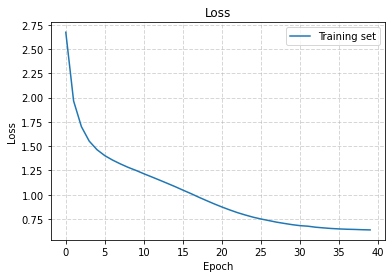

In [43]:
render_training_history(history)

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [44]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_40'

In [0]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Prediction loop](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

In [0]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
  # Evaluation step (generating text using the learned model)

  # Converting our start string to numbers (vectorizing).
  input_indices = [char2index[s] for s in start_string]
  input_indices = tf.expand_dims(input_indices, 0)

  # Empty string to store our results.
  text_generated = []

  # Here batch size == 1.
  model.reset_states()
  for char_index in range(num_generate):
      predictions = model(input_indices)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # Using a categorical distribution to predict the character returned by the model.
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
      )[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state.
      input_indices = tf.expand_dims([predicted_id], 0)

      text_generated.append(index2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [48]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: 'tis the causes of sin,
To whom my soul is faults fut of four--countenance, peace!

CAMILLO:
Since what I have said,
And, venomess some other highness
That the fatal hours why should success;
Thy dreams are nobly with his head!
Now, were you in being swhat worn, devise down their love
To such marriages he had said at once; who, if I
warrant thee, for I cannot woman's face and scrups
Against the viewee,
When my behalf; the very dead world's hermiolet?

GLOUCESTER:
I would, he dies: 'tis thereof arrays on. Weence:
ia cutt my yet, they settled promise:
Should che have a wrong.
What, will you walk.

LUCIO:
By place your son of blood with the
rebellit, and he not done.

HORTENSIO:
Well, cherish you.

Boatswain:
Doment of her,
Dreathes the vantable dreams, whiles Warwick tell me,--as you have been,
Why, that the shows that made me life and mine
To Cothat queen, when my peopled wench;
The one my maidenhood, show it no Becans, south within my bones all o'er.

BUCKINGHAM:
Now, my lord,--

In [49]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"ROMEO: ", temperature=1.5))

ROMEO: What's open moody.
Take young My drivy lord: Tranio, his happiar Lorinca is my sons.

NORTHUMBERLAND:
First, ho!

ROMEO:
Sweet, so! gr.

GRUMIO:
Rish'd--be bold,
' be but with God will never yet:
Besides, me dead; we'll quickly visit their
favour: gainstrue that barrected thus believe
Thrad firence thare the business fonds such ambrick,
Being pen in persip your perherding?

Nurse:
An ornatwe common's
fain and only son-my name's eyes,
To be so noble as an unglos
That not o to itself
At zounds to thee. Farewell, my Lord Northumberland,
Dismancel and men:
yet so is elove his side:
Tut, set; thou shamestroke off than viace hand:
She is it to this, being dead, that run them both:
If, eight thy wivown? why, beseech you,
Leadn's coming; An their names,
I will car wint at KatCaluce my tongue bring in my cook's
As Argeser-vow'd,
Of tes o' the office;
opted of two; th the worst.

PETRUCHIO:
Read the old man she, but shall not have stuff'd
Whthy thoughtsots of a fire, or virtuo.
I will dri

## Save the model

In [0]:
model_name = 'text_generation_shakespeare_rnn.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.h5 \
  ./demos/public/models/text_generation_shakespeare_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.